# The Bowel Troubles of Jackie the Cat

Jackie the cat is a foster cat that has been having bowel issues, especially constipation. As we switch her between food brands and laxative supplements, we thought we'd better plot our the quality of her poos in response to her food/supplementation.

The input data is a hand-maintained Google Sheet that I export into a csv. It contains dates and poop quality (by the [Bristol stool scale](https://en.wikipedia.org/wiki/Bristol_stool_scale)). Additionally, it also has a column for behavioural conditions (zoomies and yowling, which are a sign of distress, as well as mucus and dribbling in the poop).

A separate csv contains dates for different types of food and supplements.


In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from time import sleep
import datetime
pd.set_option('display.max_rows', 100)

`read_and_clean_data` prepares the data into a pandas dataframe.

Notably, a cat that originally came with Jackie (Finn) was moved to another home on Sep 29. Prior to this, we weren't super accurate in ascribing which poop came from which of the two cats. Therefore, I'm taking only data after Sep 29.

In [2]:
def read_and_clean_data(filename):
    """
    Reads and prepares the main poop data.
    
    Args:
        filename - Location of the input csv data.
        
    Returns:
        A cleaned dataframe. This dataframe also has rows for dates where no entries occur.
    """
    # Read and remove unnamed column with start/stop dates of food
    out = pd.read_csv(filename).iloc[:,:-1]
    # Add the year to the date string, then convert to date object
    out.date = pd.to_datetime(out.date + ', 2021').dt.date
    # Get data only after Sep 29
    out = out[out.date > datetime.datetime.strptime('2021-09-29', "%Y-%m-%d").date()]
    # Get only the poo entries, not pee entries or other entries.
    out = out[out.poo == 'yes']
    # Replace the 'yes' strings to T/F
    out['poo'] = out['poo'] == 'yes'
    # Drop the pee column
    out = out.drop(axis=1, labels=['pee'])
    # Replace AM/PM values
    out.time = out.time.apply(replace_am_pm)
    # Insert rows for missing dates (i.e. where no poop occurs)
    ## Generate list of all dates between first and last dates
    date_list = set([out.date.iloc[0] + datetime.timedelta(days=x) for x in range((out.date.iloc[-1] - out.date.iloc[0]).days + 1)])
    ## Get dates not already in the data
    missing_dates = list(date_list.difference(out.date))
    ## Add a row for each missing date, then sort by date, keeping original order for ties.
    out = pd.concat([out, pd.DataFrame([{'date': date} for date in missing_dates])])
    out = out.sort_values(axis=0, by='date', kind='stable')
    # Reset the index
    out = out.reset_index(drop=True)
    # Add column for how many days since beginning of the dataset
    out['days_since_start'] = out['date'].apply(lambda x: (x - out['date'].iloc[0]).days)
    
    return out

Since some entries have an AM/PM instead of  atime, this helper func changes AM to 10 AM, and PM to 8 PM.

In [3]:
def replace_am_pm(e):
    """Helper func to replace AM/PM to 10 AM and 8PM strings.
    
    Args:
        e: a pandas element
    
    Returns:
        Replaced string.
    """
    if e == 'AM':
        return '10:00 AM'
    elif e == 'PM':
        return '8:00 PM'
    else:
        return e  
    

When there multiple poops in a day, I will plot them in a vertical stack. This function generates the y position for plotting.

In [4]:
def generate_y_pos(df, col='date'):
    """
    Helper func to generate y position for stacking poop plots.
    
    Args:
        df: The poop dataframe
        col: The key for the date column.
        
    Returns:
        Pandas series containing a column to be assigned to the dataframe.
    """
    dates = df[col]
    out = []
    # Main loop to check how many previous rows have 
    # the same date value as the current row.
    # i.e. if this is the 4th poop of the day, the ultimate
    # value should be 4.
    for i, e in enumerate(dates, start=1):
        # The Y position of the date
        val = 0
        # The position before the current element to peek back.
        offset = val + 1
        # Continue while offset position is not past the beginning.
        while offset <= i :
            # As long as we keep finding that the dates on rows previous
            # are the same as the current row, keep incrementing the
            # val (y position), and the how much we are peeking back (offset).
            if dates.iloc[i - offset] == e:
                val += 1
                offset += 1
            else:
                break
        out.append(val)

    return pd.Series(out)

In [5]:
def read_and_clean_food_data(filename):
    """
    Reads and prepares food/supplement date data.
    
    Args:
        filename: Location of the food/supplement date csv.
        
    Returns:
        Dataframe containing food/supplement dates.
    """
    out = pd.read_csv(filename)
    # Add the year to the date strings, then convert to date object
    out['First'] = pd.to_datetime(out['First'] + ', 2021').dt.date
    out['Last'] = pd.to_datetime(out['Last'] + ', 2021').dt.date
    
    return out

In [6]:
poo_df = read_and_clean_data('./Jackie_Poop.csv')
poo_df['n_poop_of_the_day'] = generate_y_pos(poo_df)
food_df = read_and_clean_food_data('./Jackie_Food_Periods.csv')

In [7]:
poo_df.head(20)

,date,time,poo,bristol,conditions,notes,days_since_start,n_poop_of_the_day
0,2021-10-03,2:00 PM,True,2.5,NaN,"Pooped, large amount that looked like 2 long s...",0,1
1,2021-10-04,11:00 AM,True,3.0,mucus,"Poop - maybe about a 3 on the scale, still a b...",1,1
2,2021-10-05,NaN,NaN,NaN,NaN,NaN,2,1
3,2021-10-06,NaN,NaN,NaN,NaN,NaN,3,1
4,2021-10-07,NaN,NaN,NaN,NaN,NaN,4,1
5,2021-10-08,12:00 PM,True,2.5,yowl,Gave lactulose this morning (and previous 2 me...,5,1
6,2021-10-08,11:00 PM,True,2.5,NaN,"Had a second poo of the day, pretty good quali...",5,2
7,2021-10-09,NaN,NaN,NaN,NaN,NaN,6,1
8,2021-10-10,10:00 AM,True,1.5,mucus,"Had a poo, was about a 1 on one end, and like ...",7,1
9,2021-10-11,3:00 AM,True,5.0,"zoom, yowl","had the zoomies and yeowling, had a small soft...",8,1


In [8]:
food_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Type        5 non-null      object
 1   First       5 non-null      object
 2   Last        5 non-null      object
 3   Supplement  5 non-null      bool  
dtypes: bool(1), object(3)
memory usage: 253.0+ bytes


In [9]:
food_df

,Type,First,Last,Supplement
0,Lactulose + Psyllium,2021-10-03,2021-11-16,True
1,PEG (1/8 tsp),2021-11-18,2021-11-25,True
2,PEG (1/4 tsp),2021-11-26,2021-12-11,True
3,Fancy Feast,2021-10-03,2021-10-11,False
4,Performatrin/Wellness/First Mate,2021-10-12,2021-12-11,False


In [10]:
def plot_dates_bristol(df, food_period_df):
    """
    Plot dates vs the number of poop in a day, colored by bristol stool quality.
    
    Each dot on the plot represents a poop. Stacking of poops on the y axis indicates there is that many poops during that day.
    
    Args:
        df: Cleaned poop df.
        food_period_df: Cleaned food date df.
        
    Returns:
        None.
    """
    # Note: There is a lot of hard-coding values in this function.
    # It may be worth a refactor if this code get used for different cats.
    
    # Figure Sizing
    fig_width = 20
    fig_height = 2
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    
    # Set x tick location and labels
    x_ticks = df['days_since_start'].unique()
    ax.set_xlim(x_ticks.min() - 0.75, x_ticks.max() + 0.75)
    ax.set_xticks(x_ticks)
    # Set y tick location and labels
    ys = df['n_poop_of_the_day'].unique()
    ax.set_ylim(0, 4.75)
    ax.set_yticks(ys)
    
    # Food period plotting as lines on top of the plot
    for i, row in food_df.iterrows():
        # Look up each date in the 'days_since_start' col in the poop data
        x1 = df['days_since_start'][df['date'] == row['First']].iloc[0]
        x2 = df['days_since_start'][df['date'] == row['Last']].iloc[0]
        if row['Supplement']:
            # 8 and 9 are arbritary positions to place these lines.
            y1 = y2 = 8
        else:
            y1 = y2 = 9
        
        # Plot the line
        ax.plot([x1, x2], [y1, y2], clip_on=False)
        
        # Annotations for the name of the lines.
        # Italics/bold depending on if it's supplements or food.
        if row['Supplement']:
            ax.annotate(text=row['Type'], xy=(x1 + 0.25, y1 + 0.25), annotation_clip=False, style='italic')
        else:
            ax.annotate(text=row['Type'], xy=(x1 + 0.25, y1 + 0.25), annotation_clip=False, weight='bold')

    # Poop data plotting using seaborn to handle the heavy work.
    sns.scatterplot(ax=ax, data=df, x='days_since_start', y='n_poop_of_the_day', hue='bristol', s=250)
    ax.legend(bbox_to_anchor=(1.01, 1), title='Bristol Stool Scale', loc='upper left', borderaxespad=0)
    
    # Draw zoom, yowl, etc. on top of the plot
    for i, row in df[df['conditions'].notna()].iterrows():
        text = row['conditions']
        # For each condition, draw in the letter on a track located at a y.
        # These y values are arbitrary, and this would break if 
        # the number of poop per day was above 4.
        if 'zoom' in text:
            ax.annotate('Z', xy=(row['days_since_start'], 4.75), ha='center', va='center', annotation_clip=False)
        if 'yowl' in text:
            ax.annotate('Y', xy=(row['days_since_start'], 5.25), ha='center', va='center', annotation_clip=False)
        if 'mucus' in text:
            ax.annotate('M', xy=(row['days_since_start'], 5.75), ha='center', va='center', annotation_clip=False)
        if 'dribbles' in text:
            ax.annotate('D', xy=(row['days_since_start'], 6.25), ha='center', va='center', annotation_clip=False)
            
    # Condition annotation "Legend"
    ax.annotate("Z: zoomies, Y: yowling, M: mucus, D: dribbles", xy=(0,6.75), va='center', annotation_clip=False)
    
    # Remove top and right border
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Better axis labels
    ax.set_xlabel(f"Days Since {df['date'].iloc[0].strftime('%b %d, %Y')}")
    ax.set_ylabel("Poops Per Day")
    
    return fig

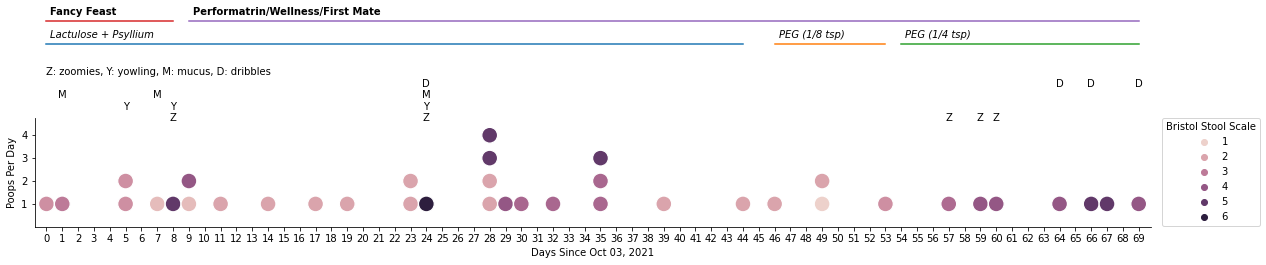

In [11]:
figure = plot_dates_bristol(poo_df, food_df)

In [12]:
# Save the figure.
figure.savefig('output.png', dpi=300, bbox_inches='tight', facecolor='white')